# test for interpolation routine with feiss GPU

In [39]:
from torch import nn
import torch.nn.functional as F
import torch
import os
import sys
import matplotlib.pyplot as plt

In [7]:
# -----------------------------
# add "src" as import path
path = os.path.join('/home/tsuyoshi/local_transformation_model/src/')
sys.path.append(path)

In [8]:
import numpy as np
#from src_rev_bilinear.rev_bilinear_interp import RevBilinear
from nearest_neighbor_interp import nearest_neighbor_interp_fe

In [10]:
def grid_to_pc_nearest(R_grd,XY_pc,XY_grd):
    # convert grid to pc
    # R_grd: grid value with [batch,channels,height,width] dim
    # XY_pc: point cloud position with [batch,2,N] dim
    #        scaled to [0,1]
    batch,k,height,width = R_grd.shape
    XY_grd_tmp = XY_grd.reshape(batch,2,height*width).permute(0,2,1).detach()
    XY_pc_tmp = XY_pc.permute(0,2,1).detach()
    R_grd_tmp = R_grd.reshape(batch,k,height*width)
    #R_pc = nearest_neighbor_interp(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    #R_pc = nearest_neighbor_interp_kd(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    R_pc = nearest_neighbor_interp_fe(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    #import pdb;pdb.set_trace()
    return R_pc

In [12]:
def pc_to_grid_nearest(R_pc,XY_pc,XY_grd):
    # convert pc to grid
    # R_pc: point cloud value with [batch,channels,N] dim
    # XY_pc: point cloud position with [batch,2,N] dim
    #        scaled to [0,1]
    batch,_,height,width = XY_grd.shape
    _,k,_ = R_pc.shape
    XY_grd_tmp = XY_grd.reshape(batch,2,height*width).permute(0,2,1).detach()
    XY_pc_tmp = XY_pc.permute(0,2,1).detach()
    #R_grd = nearest_neighbor_interp(XY_grd_tmp,XY_pc_tmp,R_pc)
    #R_grd = nearest_neighbor_interp_kd(XY_grd_tmp,XY_pc_tmp,R_pc)
    #R_grd = nearest_neighbor_interp_kd(XY_pc_tmp,XY_grd_tmp,R_pc)
    R_grd = nearest_neighbor_interp_fe(XY_grd_tmp,XY_pc_tmp,R_pc)
    #import pdb;pdb.set_trace()
    R_grd = R_grd.reshape(batch,k,height,width)
    return R_grd

## Dims

In [93]:
bsize = 10
tsize = 12
channels = 1
# Grid Size
#height = 10
#width = 10
height = 200
width = 200
# Particle Size
npc = 40000

In [94]:
def xy_grid(height,width):
    # generate constant xy grid
    x1grd = torch.linspace(0,1,width).cuda() # 1d grid
    y1grd = torch.linspace(0,1,height).cuda() # 1d grid

    Xgrid = torch.zeros(height, width)
    Ygrid = torch.zeros(height, width)
    for j in range(height):
        Xgrid[j,:] = x1grd
    for k in range(width):
        Ygrid[:,k] = y1grd
    return Xgrid,Ygrid

## Prepare Grids

In [95]:
Xgrid,Ygrid = xy_grid(height,width)

In [96]:
# Set Initial Grid (which will be fixed through time progress)
X_grd = torch.stack(bsize*[Xgrid]).unsqueeze(1)
Y_grd = torch.stack(bsize*[Ygrid]).unsqueeze(1)
XY_grd = torch.cat([X_grd,Y_grd],dim=1).cuda()
# Set Initial PC
#XY_pc = torch.zeros(bsize,2,npc).cuda()
XY_pc = torch.rand(bsize,2,npc).cuda() #[0-1]

In [97]:
XY_pc.shape

torch.Size([10, 2, 40000])

In [98]:
XY_grd.shape

torch.Size([10, 2, 200, 200])

In [99]:
# Set initial rain field

In [100]:
ic=0.5
jc=0.5
scale=0.2
R_grd = torch.exp(-((X_grd-ic)**2 + (Y_grd-jc)**2)/scale**2)
R_grd = R_grd.cuda()

In [101]:
R_grd.shape

torch.Size([10, 1, 200, 200])

ValueError: 'c' argument has 20000 elements, which is inconsistent with 'x' and 'y' with size 40000.

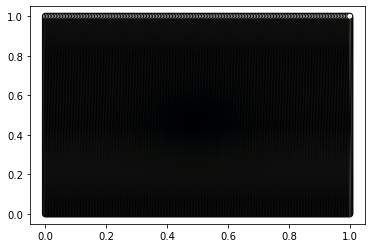

In [102]:
# test plot for initial grid
x = XY_grd[0,0,:].detach().cpu().numpy()
y = XY_grd[0,1,:].detach().cpu().numpy()
value = R_grd[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="black")
x = XY_pc[0,0,:].detach().cpu().numpy()
y = XY_pc[0,1,:].detach().cpu().numpy()
value = R_pc[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="red")

In [103]:
#set UV
UV_grd = torch.zeros(bsize,tsize, 2,height, width).cuda()
UV_grd = UV_grd + 0.07

In [104]:
%%time
#it = 0
# loop through time dim
for it in range(tsize):
    # convert R and UV to point cloud
    UV_pc = grid_to_pc_nearest(UV_grd[:,it,:,:,:],XY_pc,XY_grd)
    R_pc = grid_to_pc_nearest(R_grd[:,:,:,:],XY_pc,XY_grd)
    # time progress
    XY_pc = XY_pc + UV_pc
    # go back to grid
    R_grd = pc_to_grid_nearest(R_pc,XY_pc,XY_grd)

CPU times: user 19.4 s, sys: 2.78 s, total: 22.2 s
Wall time: 16 s


In [76]:
tsize

12

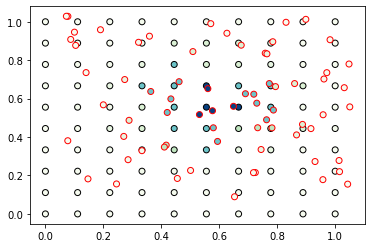

In [75]:
# test plot for initial grid
x = XY_grd[0,0,:].detach().cpu().numpy()
y = XY_grd[0,1,:].detach().cpu().numpy()
value = R_grd[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="black")
x = XY_pc[0,0,:].detach().cpu().numpy()
y = XY_pc[0,1,:].detach().cpu().numpy()
value = R_pc[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="red")

In [74]:
XY_grd.shape

torch.Size([10, 2, 10, 10])